# Proyecto Interconnect

El operador de telecomunicaciones Interconnect nos ha pedido pronosticar la tasa de cancelación de los clientes.
Quiere poder identificar que usuarios están por abandonar el servicio y ofrecerles códigos promocionales y planes especiales para evitar su abandono.

Para ello nos han brindado con la siguiente información:

· Una base de datos con la información de los contratos.

· Una base con los servicios contratados de Internet: streaming, seguridad, soporte.

· Una base con la información de los usuarios y sus dependientes.

· Una base con las líneas telefónicas contratadas.

Con esta información debemos de crear un modelo que pronostique el abandono de los usuarios y ofrecerles una promoción antes de que decidan abandonar el servicio.

# 1. Plan de Trabajo

Objetivo: crear un modelo de predicción que nos permita ofrecer una promoción a los clientes que van a abandonar el servicio.
Para ello vamos a crear un modelo de clasificación que nos permita identificar que usuario va a abandonar el servicio, usando las características de comportamiento provistas por el cliente.
Este modelo debe de tener una exactitud de al menos el 0.85, una precisión de al menos 0.8 y usaremos el ECM cómo métrica de error.
Debemos de iterar el proyecto para reducir el error lo más posible.
Conseguir llegar a un AUC-ROC mayor o igual a 0.88

Prioridades:
1. Análisis Exploratorio de Datos: primero debemos entender la información disponible. Es necesario entender si debemos limpiar y transformar los datos ante de empezar a trabajar con ellos.
Después de haber tratado la información debemos de presentarla de manera gráfica para conocer los pesos y el sesgo de la información.
Esto nos dará una idea de si debemos de ajustar de los datos, para no sobreentrenar el modelo.
También debemos de conocer nuestra muestra para establecer cuales serían nuestros objetivos de entrenamientos y las características disponibles para entrenarlos.

2. Definir métricas de evaluación, error y realizar pruebas: al tener la información analizada y limpia, debemos de crear datasets de entrenamiento y validación.
Con esta información podemos empezar a entrenar modelos e iterarlos para llegar a la meta propuesta. 
En esta sección vamos a definir como se van a usar nuestras métricas de evaluación, cómo vamos a medir el error y hacer pruebas con distintos modelos de clasificación.
Esta sección nos va a ayudar a definir cual sería el modelo ideal para la tarea.

3. Entrenar el modelo: en esta sección vamos a entrenar el modelo con las características ideales para la tarea. 
Aquí vamos a utilizar los parámetros para iterar sobre el modelo y definir cuales son las métricas adecuadas para tener el modelo más eficiente usando los menos recursos posibles.

4. Conclusiones: finalmente vamos a dar a conocer las conclusiones generales del proyecto.
Describiendo por qué es necesario usar dichas características para entrenar el modelo.
Dar a conocer el porqué eligimos el modelo final, su eficiencia, la decisión detrás de sus parámetros y por que es ideal para resolver esta tarea.


# 1. Análisis Exploratorio de Datos

# 1.1 Carga de Datos

In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
import sklearn
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

In [4]:
df_contracts = pd.read_csv('/datasets/final_provider/contract.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

# 1.2 Limpieza de Datos y Transformación

In [5]:
print('DataFrame Contratos')
df_contracts.info()
print()
print('DataFrame Plan de Internet')
df_internet.info()
print()
print('DataFrame Usuarios')
df_personal.info()
print()
print('DataFrame Líneas Telefónicas')
df_phone.info()

DataFrame Contratos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

DataFrame Plan de Internet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-

Podemos observar que nuestros datos se cargaron correctamente y tenemos 4 bases para trabajar.
Estas bases no presentan datos nulos y comparten la columa de 'customerID', esta nos va a servir para juntar las bases de datos.
Las bases no presentan la misma cantidad de datos de clientes, así que hay información faltante con la que vamos a tener que trabajar.
Ahora vamos a tomar una muestra de cada base de datos y transformar los tipos de datos necesarios para poder trabajar con ellos.

In [6]:
print('DataFrame Contratos')
display(df_contracts.head(10))
print()
print('DataFrame Plan de Internet')
display(df_internet.head(10))
print()
print('DataFrame Usuarios')
display(df_personal.head(10))
print()
print('DataFrame Líneas Telefónicas')
display(df_phone.head(10))

DataFrame Contratos


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95



DataFrame Plan de Internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No



DataFrame Usuarios


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes



DataFrame Líneas Telefónicas


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [7]:
df_contracts.sort_values(by=['TotalCharges'], ascending=True)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
...,...,...,...,...,...,...,...,...
6646,8249-THVEC,2015-11-01,No,One year,No,Mailed check,19.40,997.75
5598,6051-PTVNS,2015-07-01,No,One year,No,Credit card (automatic),19.15,998.1
3686,5899-MQZZL,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Mailed check,75.00,999.45
3353,4536-PLEQY,2019-02-01,No,Month-to-month,Yes,Credit card (automatic),85.05,999.8


Como podemos observar hay información faltante en la columna de TotalCharges, debido a esta falta de información nuestro modelo podría entrenarse de manera errónea.
Vamos a utilizar el método KNNImputer para rellenar la información faltante, después de eso podremos continuar a tratar la información y luego concatenar las bases.

In [8]:
df_contracts['TotalCharges'] = df_contracts['TotalCharges'].replace(' ', 'NaN')

In [9]:
imputer = KNNImputer(n_neighbors=2)
df_contracts['TotalCharges'] = imputer.fit_transform(df_contracts[['TotalCharges']])

In [10]:
df_contracts.sort_values(by=['TotalCharges'], ascending=True)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1654,2967-MXRAV,2020-01-01,No,One year,No,Mailed check,18.80,18.80
6489,9318-NKNFC,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,18.85,18.85
1151,8992-CEUEN,2020-01-01,No,Month-to-month,No,Electronic check,18.85,18.85
4939,9975-SKRNR,2020-01-01,No,Month-to-month,No,Mailed check,18.90,18.90
583,1423-BMPBQ,2020-01-01,No,Month-to-month,Yes,Mailed check,19.00,19.00
...,...,...,...,...,...,...,...,...
2187,8879-XUAHX,2014-03-01,No,Two year,Yes,Electronic check,116.25,8564.75
5347,9788-HNGUT,2014-02-01,No,Two year,Yes,Credit card (automatic),116.95,8594.40
6768,9739-JLPQJ,2014-02-01,No,Two year,No,Credit card (automatic),117.50,8670.10
4586,7569-NMZYQ,2014-02-01,No,Two year,Yes,Bank transfer (automatic),118.75,8672.45


In [11]:
print(df_contracts.duplicated().sum())
print(df_internet.duplicated().sum())
print(df_personal.duplicated().sum())
print(df_phone.duplicated().sum())

0
0
0
0


Conociendo esta información vamos a transformar los datos de los pagos a numéricos numéricos volviéndolos a tipo float. 
Esta información no nos brinda una características sino la cantidad monetaria que pagan los usuarios por los servicios.

También los datos de fecha serán transformados a datetime para poderlos usar como fechas.

El resto de los datos los podemos transformar en un futuro a booleandos usando el método One Hit, esto después de haber concatenado nuestras bases de datos

In [12]:
df_contracts['TotalCharges'] = df_contracts['TotalCharges'].astype('float64')

df_contracts['BeginDate'] = pd.to_datetime(df_contracts['BeginDate'])

df_contracts['EndDate'] = pd.to_datetime(df_contracts['EndDate'], errors='ignore')

df_contracts.info()
print()
print(df_contracts['EndDate'].head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB

0                     No
1                     No
2    2019-12-01 00:00:00
3                     No
4    2019-11-01 00:00:00
5    2019-11-01 00:00:00
6                     No
7                     No
8    2019-11-01 00:00:00
9                     No
Name: EndDate, dtype: object


In [13]:
df_merge_1 = df_contracts.merge(df_internet, how='outer', right_on='customerID', left_on='customerID')
df_merge_2 = df_merge_1.merge(df_personal, how='outer', right_on='customerID', left_on='customerID')
df_merged = df_merge_2.merge(df_phone, how='outer', right_on='customerID', left_on='customerID')

display(df_merged.head(10))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.50,Fiber optic,No,No,Yes,No,Yes,Yes,Female,0,No,No,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Fiber optic,No,Yes,No,No,Yes,No,Male,0,No,Yes,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,DSL,Yes,No,No,No,No,No,Female,0,No,No,NaN
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Fiber optic,No,No,Yes,Yes,Yes,Yes,Female,0,Yes,No,Yes
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,DSL,Yes,Yes,No,No,No,No,Male,0,No,Yes,No


Agregamos una nueva columna de Usuarios Activos, para poder separar la cantidad de usarios que tenemos que siguen con un servicio activo de telefonía y los que ya abandonaron los servicios.

In [14]:
pd.set_option('display.max_columns', None)
df_merged['ActiveCustomers'] = np.where(df_merged['EndDate'] == 'No', 1, 0)
display(df_merged.head(10))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,ActiveCustomers
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,1
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN,1
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,0
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.50,Fiber optic,No,No,Yes,No,Yes,Yes,Female,0,No,No,Yes,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Fiber optic,No,Yes,No,No,Yes,No,Male,0,No,Yes,Yes,1
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,DSL,Yes,No,No,No,No,No,Female,0,No,No,NaN,1
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Fiber optic,No,No,Yes,Yes,Yes,Yes,Female,0,Yes,No,Yes,0
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,DSL,Yes,Yes,No,No,No,No,Male,0,No,Yes,No,1


In [15]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovies   5517 n

Podemos observar que al momento de concatenar las bases de datos nos hace faltan datos.
Estos datos nulos son sobre los servicios de ofrecidos por la compañía y en caso de que los clientes tengan más de una línea telefónica.
En este caso no podemos usar KNNImputer para rellenar esta data, ya que sólo funciona para datos numéricos.
Por eso hemos decidido rellenar los datos con un 'No', ya que no sabemos si realmente tiene activado el servicio o no.

In [16]:
df_merged = df_merged.fillna('No')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   InternetService   7043 non-null   object        
 9   OnlineSecurity    7043 non-null   object        
 10  OnlineBackup      7043 non-null   object        
 11  DeviceProtection  7043 non-null   object        
 12  TechSupport       7043 non-null   object        
 13  StreamingTV       7043 non-null   object        
 14  StreamingMovies   7043 n

<AxesSubplot:title={'center':'Usuarios Activos vs. Abandono'}>

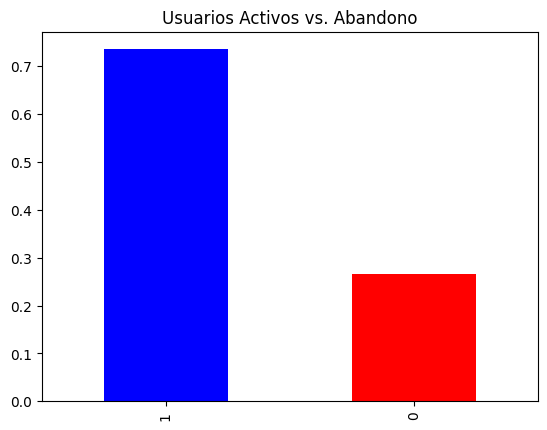

In [17]:
hist_active_users = df_merged['ActiveCustomers'].value_counts(normalize=True)

plt.title("Usuarios Activos vs. Abandono")
hist_active_users.plot.bar(color=['blue','red'])


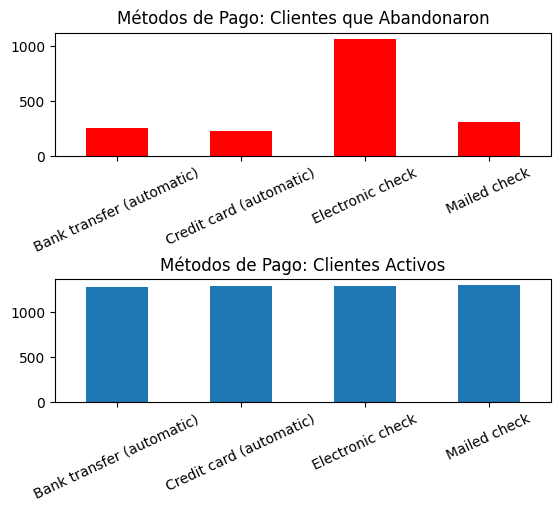

In [18]:
hist_churn_pay = df_merged.query("ActiveCustomers == 0")[['PaymentMethod', 'ActiveCustomers']]
hist_churn_pay = hist_churn_pay.groupby(['PaymentMethod'])['ActiveCustomers'].count()

hist_act_pay = df_merged.query("ActiveCustomers == 1")[['PaymentMethod', 'ActiveCustomers']]
hist_act_pay = hist_act_pay.groupby(['PaymentMethod'])['ActiveCustomers'].count()

plt.subplot(211)
hist_churn_pay.plot.bar(color='red')
plt.title("Métodos de Pago: Clientes que Abandonaron")
plt.xticks(rotation=25)
plt.xlabel('')
plt.subplot(212)
hist_act_pay.plot.bar()
plt.title("Métodos de Pago: Clientes Activos")
plt.xticks(rotation=25)
plt.subplots_adjust(hspace = 1)
plt.xlabel('')
plt.show()

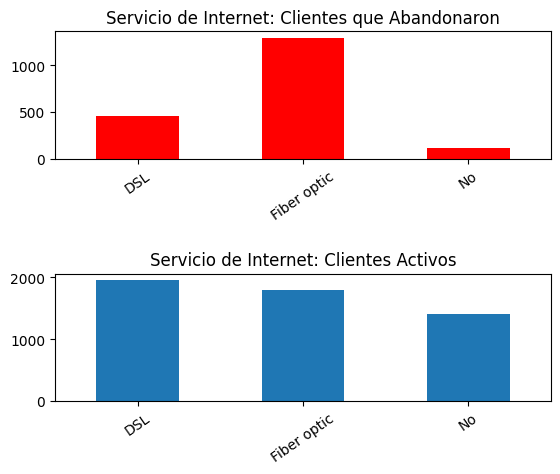

In [19]:
hist_churn_int = df_merged.query("ActiveCustomers == 0")[['InternetService', 'ActiveCustomers']]
hist_churn_int = hist_churn_int.groupby(['InternetService'])['ActiveCustomers'].count()

hist_act_int = df_merged.query("ActiveCustomers == 1")[['InternetService', 'ActiveCustomers']]
hist_act_int = hist_act_int.groupby(['InternetService'])['ActiveCustomers'].count()

plt.subplot(211)
hist_churn_int.plot.bar(color='red')
plt.title("Servicio de Internet: Clientes que Abandonaron")
plt.xticks(rotation=35)
plt.xlabel('')
plt.subplot(212)
hist_act_int.plot.bar()
plt.title("Servicio de Internet: Clientes Activos")
plt.xticks(rotation=35)
plt.subplots_adjust(hspace = 0.9)
plt.xlabel('')
plt.show()

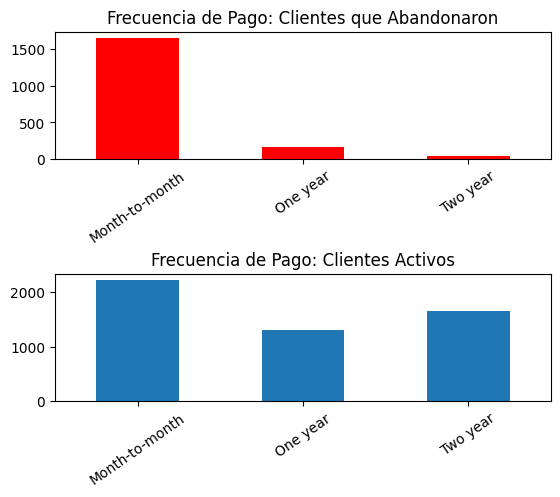

In [20]:
hist_churn_type = df_merged.query("ActiveCustomers == 0")[['Type', 'ActiveCustomers']]
hist_churn_type = hist_churn_type.groupby(['Type'])['ActiveCustomers'].count()

hist_act_type = df_merged.query("ActiveCustomers == 1")[['Type', 'ActiveCustomers']]
hist_act_type = hist_act_type.groupby(['Type'])['ActiveCustomers'].count()

plt.subplot(211)
hist_churn_type.plot.bar(color='red')
plt.title("Frecuencia de Pago: Clientes que Abandonaron")
plt.xticks(rotation=35)
plt.xlabel('')
plt.subplot(212)
hist_act_type.plot.bar()
plt.title("Frecuencia de Pago: Clientes Activos")
plt.xticks(rotation=35)
plt.subplots_adjust(hspace = 0.9)
plt.xlabel('')
plt.show()

# 1.3 Conclusiones EDA

En las gráficas previas podemos observar que tenemos una base de datos que contiene más información sobre los usuarios activos.
Esto nos indica que la información está sesgada a los clientes que siguen dentro de la compañía, tendremos que hacer un ajuste a los datos para que el modelo no se sobre trabaje con la data de clientes activos.

También observamos que los clientes que abandonan el servicio tienen una inclinación a abandonar el servicio si su método de pago es electrónico y si los que tienen contratado fibra óptica.

Hay que analizar estos factores ya que puede ser que se les facilite cancelar el servicio si el método de pago es a través de un cobro electrónico.
Valdría la pena conocer el estatus del servicio de fibra óptica, fallas en este servicio puede estar causando que los usuarios decidan abandonar el servicio.
Por último, para los clientes que pagan el servicio mes con mes se les facilita más cancelar el servicio, será mejor empujar promociones de pagos de servicios anuales o a dos años.

# 2. Datasets de Entrenamiento y Validación

En esta sección vamos a seguir trabajando con nuestros datos y definir como se van a dividir nuestros datasets de entrenamiento y validación.

Para ello vamos a remover la información que nos hagan ruido y que realmente no sea necesaria para el entrenamiento del modelo.

Luego ajustaremos nuestras muestras para evitar el sobreentrenamiento de 

En esta sección también vamos a codificar las características para entrenar nuestro modelo, de manera que sea más sencillo al CPU entrenar el modelo.

In [21]:
variables_categoricas = ['Type', 'PaymentMethod','InternetService','OnlineSecurity','OnlineBackup', 'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Partner','Dependents','MultipleLines']
variables_numericas = ['MonthlyCharges','TotalCharges']
variables_no_informativas = ['customerID', 'BeginDate','EndDate','PaperlessBilling','gender','SeniorCitizen']

df_merged = df_merged.drop(variables_no_informativas, axis=1)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaymentMethod     7043 non-null   object 
 2   MonthlyCharges    7043 non-null   float64
 3   TotalCharges      7043 non-null   float64
 4   InternetService   7043 non-null   object 
 5   OnlineSecurity    7043 non-null   object 
 6   OnlineBackup      7043 non-null   object 
 7   DeviceProtection  7043 non-null   object 
 8   TechSupport       7043 non-null   object 
 9   StreamingTV       7043 non-null   object 
 10  StreamingMovies   7043 non-null   object 
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  MultipleLines     7043 non-null   object 
 14  ActiveCustomers   7043 non-null   int64  
dtypes: float64(2), int64(1), object(12)
memory usage: 880.4+ KB


In [22]:
df_merged[['MonthlyCharges','TotalCharges']].describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2283.300441
std,30.090047,2265.000258
min,18.250000,18.800000
25%,35.500000,402.225000
50%,70.350000,1400.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


In [23]:
scaler = StandardScaler()
df_merged['TotalCharges'] = scaler.fit_transform(df_merged[['TotalCharges']])

display(df_merged)

,Type,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Partner,Dependents,MultipleLines,ActiveCustomers
0,Month-to-month,Electronic check,29.85,-0.994971,DSL,No,Yes,No,No,No,No,Yes,No,No,1
1,One year,Mailed check,56.95,-0.173876,DSL,Yes,No,Yes,No,No,No,No,No,No,1
2,Month-to-month,Mailed check,53.85,-0.960399,DSL,Yes,Yes,No,No,No,No,No,No,No,0
3,One year,Bank transfer (automatic),42.30,-0.195400,DSL,Yes,No,Yes,Yes,No,No,No,No,No,1
4,Month-to-month,Electronic check,70.70,-0.941193,Fiber optic,No,No,No,No,No,No,No,No,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,Mailed check,84.80,-0.129281,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,1
7039,One year,Credit card (automatic),103.20,2.242808,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,1
7040,Month-to-month,Electronic check,29.60,-0.855182,DSL,Yes,No,No,No,No,No,Yes,Yes,No,1
7041,Month-to-month,Mailed check,74.40,-0.872777,Fiber optic,No,No,No,No,No,No,Yes,No,Yes,0


In [24]:
df_merged_one = pd.get_dummies(df_merged, drop_first=True, columns=variables_categoricas)
display(df_merged_one)

,MonthlyCharges,TotalCharges,ActiveCustomers,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Partner_Yes,Dependents_Yes,MultipleLines_Yes
0,29.85,-0.994971,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
1,56.95,-0.173876,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
2,53.85,-0.960399,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0
3,42.30,-0.195400,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0
4,70.70,-0.941193,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,84.80,-0.129281,1,1,0,0,0,1,0,0,1,0,1,1,1,1,1,1,1
7039,103.20,2.242808,1,1,0,1,0,0,1,0,0,1,1,0,1,1,1,1,1
7040,29.60,-0.855182,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0
7041,74.40,-0.872777,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1


Como observamos en las lineas de código, nos deshicimos de las características no informativas. Estas características no nos dan información sobre el comportamiento del usuario, así que no son necesarias para entrenar el modelo.

Después de esto realizamos una descripción de los datos para ver los rangos en las cantidades de los cargos mensuales y totales.
Al ver que el rango de los cargos totales era muy amplio lo escalamos para que el modelo se pueda entrenar con esta información de manera más sencilla.

Por último, utilizamos una codificación OneHot para tratar los datos de cierta manera que puedan ser más sencillo para que el modelo los pueda leer.

In [25]:
entre_valid, prueba = train_test_split(df_merged_one, test_size=0.3, random_state=12345)
entrenamiento, valid = train_test_split(entre_valid, test_size=0.25, random_state=12345)

In [26]:
caract_entre = entrenamiento.drop('ActiveCustomers', axis=1)
obj_entre = entrenamiento['ActiveCustomers']

caract_valid = valid.drop('ActiveCustomers', axis=1)
obj_valid = valid['ActiveCustomers']

caract_prueba = prueba.drop('ActiveCustomers', axis=1)
obj_prueba = prueba['ActiveCustomers']

In [27]:
print(caract_entre.shape)
print(caract_valid.shape)
print(caract_prueba.shape)

(3697, 18)
(1233, 18)
(2113, 18)


# 2.1 Bootsrtapping

Como observamos previamente tenemos más información sobre los usuarios que siguen activos en el banco a comparación con los que han abandonado los servicios.

Debido a esto vamos a utilizar el método Bootstrapping para aumentar las características de la clase más rara, de esta manera el modelo no se va a sesgar a pronosticar que los clientes no van a abandonar el servicio.

In [28]:
def aumento_sample(caracteristicas, objetivo, repetir):
    caract_ceros = caracteristicas[objetivo == 0] #Dividimos las características y objetivos por clase
    caract_unos = caracteristicas[objetivo == 1]
    objetivo_ceros = objetivo[objetivo == 0]
    objetivo_unos = objetivo[objetivo == 1]

    caract_aumento = pd.concat([caract_unos] + ([caract_ceros] * repetir)) #Concateneamos o juntamos las características y objetivos aumentado la clase menos frecuente
    objetivo_aumento = pd.concat([objetivo_unos] + ([objetivo_ceros] * repetir))

    caract_aumento, objetivo_aumento = shuffle( #Barajeamos la información de la data para que se presente al azar
        caract_aumento, objetivo_aumento, random_state=12345
    )

    return caract_aumento, objetivo_aumento

In [29]:
caract_entre, obj_entre = aumento_sample(caract_entre, obj_entre, 3)

In [30]:
caract_valid, obj_valid = aumento_sample(caract_valid, obj_valid, 3)

In [31]:
caract_prueba, obj_prueba = aumento_sample(caract_prueba, obj_prueba, 3)

Decidí aumentar las cantidad de datos para la clase rara (0) en 3 veces más. Ya que los clientes activos (1) representan más del 75% de los datos disponibles, mientras que los usuarios que abandonaron (0) representan un 25% de los datos.

In [32]:
print(caract_entre.shape) #Validamos el bootstrapping
print(caract_valid.shape)
print(caract_prueba.shape)

(5663, 18)
(1857, 18)
(3261, 18)


<AxesSubplot:title={'center':'Usuarios Activos vs. Abandono'}>

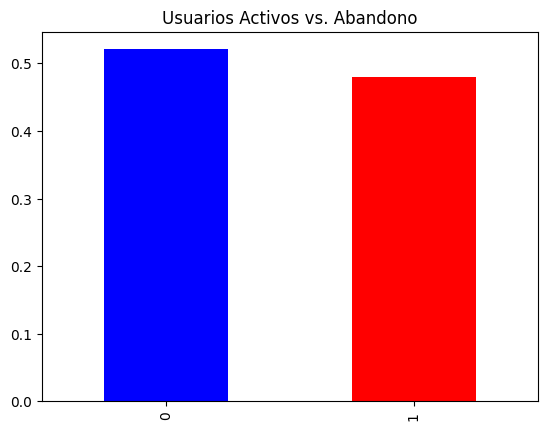

In [33]:
hist_bootstrap = obj_entre.value_counts(normalize=True) #Validamos que se haya aumentado la cantidad de características de clientes que han abandonado el servicio.

plt.title("Usuarios Activos vs. Abandono")
hist_bootstrap.plot.bar(color=['blue','red'])

# 2.2 Definir funciones con métricas de validación

Ahora vamos a definir una función que nos ayude a ver que tan eficente es nuestro modelo.

De esta manera podremos definir cual va a ser nuestro modelo ideal.

In [34]:
def evaluate_model(model, caract_entre, obj_entre, caract_prueba, obj_prueba):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, caracteristicas, objetivo in (('train', caract_entre, obj_entre), ('test', caract_prueba, obj_prueba)):
        
        eval_stats[type] = {}
    
        pred_obj = model.predict(caracteristicas)
        pred_proba = model.predict_proba(caracteristicas)[:, 1]
        
        # F1
        f1_rango = np.arange(0, 1.01, 0.05)
        f1_calif = [metrics.f1_score(objetivo, pred_proba>=threshold) for threshold in f1_rango]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(objetivo, pred_proba)
        roc_auc = metrics.roc_auc_score(objetivo, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(objetivo, pred_proba)
        aps = metrics.average_precision_score(objetivo, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_calif)
        ax.plot(f1_rango, f1_calif, color=color, label=f'{type}, max={f1_calif[max_f1_score_idx]:.2f} @ {f1_rango[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_rango-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_rango[closest_value_idx], f1_calif[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(objetivo, pred_obj)
        eval_stats[type]['F1'] = metrics.f1_score(objetivo, pred_obj)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

In [35]:
def rmse(valid, predict): #Definimos nuestra métrica de error
    return math.sqrt(mean_squared_error(valid, predict))

# 3. Entrenar nuestros modelos

Ahora que ya hemos limpiado la información, la trabajamos para usarla en los modelos y definimos nuestras métricas de valuación, ya podemos entrenar a los modelos.

Para esto iremos entrenando a los modelos y cambiaremos sus parámetros para llegar al resultado más eficientes.

Después de esto vamos a evaluar nuestros modelos para seleccionar cual es el ideal para esta tarea.

# 3.1 Primero modelo: DecisionTreeClassifier

Empecemos entrenando al modelo más sencillo, veamos como se comporta una árbol de clasificación para ver si este recurso es lo suficientemente capaz de lograr los objetivos de la tarea.

In [36]:
modelo_tree = DecisionTreeClassifier(random_state=54321)

In [37]:
modelo_tree.fit(caract_entre, obj_entre)

DecisionTreeClassifier(random_state=54321)

          train  test
Accuracy    1.0  0.67
F1          1.0  0.69
APS         1.0  0.58
ROC AUC     1.0  0.67


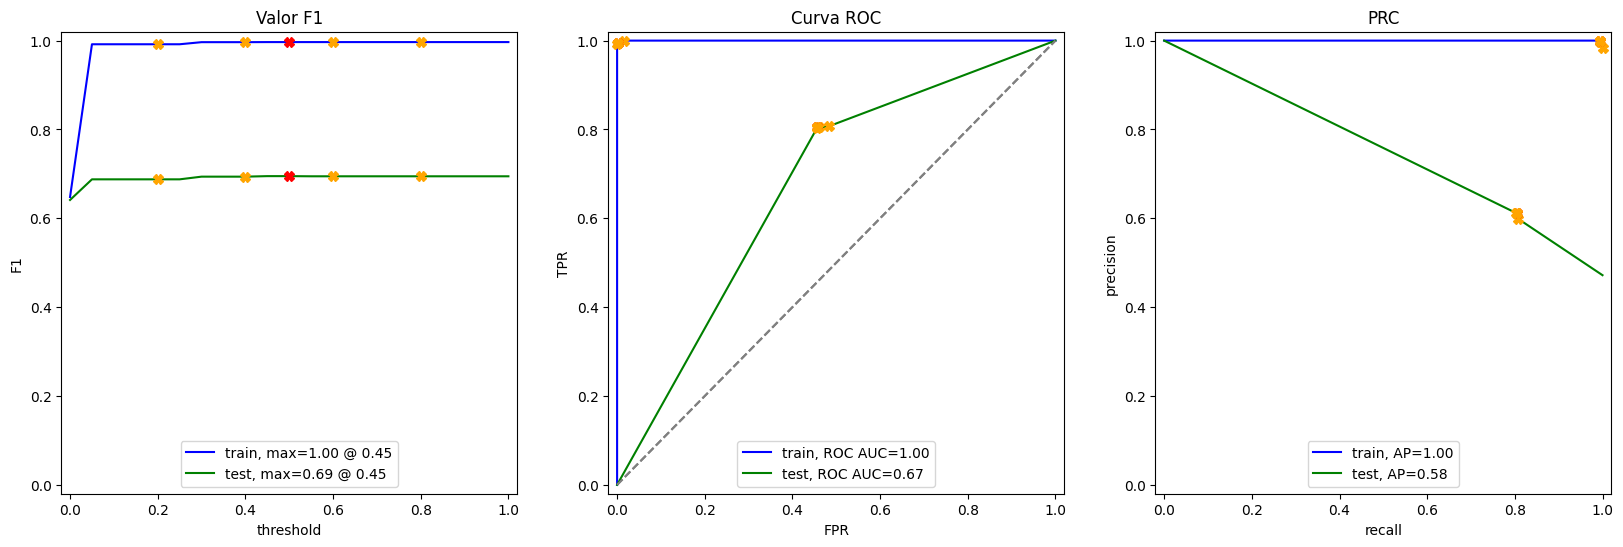

In [38]:
evaluate_model(modelo_tree, caract_entre, obj_entre, caract_prueba, obj_prueba)

# Conclusiones: DecisionTreeClassifier

Este recurso aunque es sencillo nos da una idea de como trabaja un modelo de clasificación con un árbol de clasificación.
En este caso, este modelo no llega a satisfacer nuestro objetivo, el ROC AUC está por debajo de nuestro objetivo lo cual no lo hace satisfactorio para la tarea en sí.

# 3.2 Segundo modelo: RandomForestClassifier

Ahora utilicemos un modelo más robusto, usaremso el clasificador tipo bosque donde podemos tener más un de árbol de clasificación.

Esto nos va a permitir llegar a conclusiones de pronóstico más pulidas.

In [39]:
for trees in range(2, 15): #Haremos un for para escoger la cantidad de árboles que hacen más eficiente el modelo.
     forest_model = RandomForestClassifier(n_estimators=trees, max_depth=6, random_state=12345)
     forest_model.fit(caract_entre, obj_entre)
     forest_predict = forest_model.predict(caract_prueba)
     pred_proba = forest_model.predict_proba(caract_valid)[:,1]
     aps = metrics.average_precision_score(obj_valid, pred_proba)
     print("Cantidad de árboles:", trees)
     print("Valuación de dataset de prueba en RandomForestClassifier: ", forest_model.score(caract_prueba, obj_prueba))
     print('F1:', metrics.f1_score(obj_prueba, forest_predict))
     print('ROC AUC:', metrics.roc_auc_score(obj_valid, pred_proba))
     print('APS:', aps)
     print()

Cantidad de árboles: 2
Valuación de dataset de prueba en RandomForestClassifier:  0.7589696412143514
F1: 0.740079365079365
ROC AUC: 0.8081708148890558
APS: 0.7842814702067602

Cantidad de árboles: 3
Valuación de dataset de prueba en RandomForestClassifier:  0.7528365532045385
F1: 0.7222605099931083
ROC AUC: 0.8202552966396615
APS: 0.8227316099506308

Cantidad de árboles: 4
Valuación de dataset de prueba en RandomForestClassifier:  0.7657160380251457
F1: 0.7399591558883593
ROC AUC: 0.8231889807622707
APS: 0.8303931479754031

Cantidad de árboles: 5
Valuación de dataset de prueba en RandomForestClassifier:  0.7675559644280895
F1: 0.7425271739130435
ROC AUC: 0.8260565438904202
APS: 0.8382554192345051

Cantidad de árboles: 6
Valuación de dataset de prueba en RandomForestClassifier:  0.7641827660226924
F1: 0.7394103693663165
ROC AUC: 0.8301282051282051
APS: 0.8400295690138541

Cantidad de árboles: 7
Valuación de dataset de prueba en RandomForestClassifier:  0.7669426556271083
F1: 0.743762643

In [40]:
for depth in range(4, 10): #Haremos un for para escoger la profunidad máxima ideal para el modelo.
     forest_model = RandomForestClassifier(n_estimators=10, max_depth=depth, random_state=12345)
     forest_model.fit(caract_entre, obj_entre)
     forest_predict = forest_model.predict(caract_prueba)
     pred_proba = forest_model.predict_proba(caract_valid)[:,1]
     aps = metrics.average_precision_score(obj_valid, pred_proba)
     print("Profunidad árboles:", depth)
     print("Valuación de dataset de prueba en RandomForestClassifier: ", forest_model.score(caract_prueba, obj_prueba))
     print('F1:', metrics.f1_score(obj_prueba, forest_predict))
     print('ROC AUC:', metrics.roc_auc_score(obj_valid, pred_proba))
     print('APS:', aps)
     print()

Profunidad árboles: 4
Valuación de dataset de prueba en RandomForestClassifier:  0.7690892364305428
F1: 0.7377220480668757
ROC AUC: 0.8318960717169186
APS: 0.8441145964288191

Profunidad árboles: 5
Valuación de dataset de prueba en RandomForestClassifier:  0.7614228764182766
F1: 0.7339261285909713
ROC AUC: 0.8314923856454801
APS: 0.8389934183022576

Profunidad árboles: 6
Valuación de dataset de prueba en RandomForestClassifier:  0.769702545231524
F1: 0.7439481759290828
ROC AUC: 0.8343425485119298
APS: 0.8440932567746092

Profunidad árboles: 7
Valuación de dataset de prueba en RandomForestClassifier:  0.7651027292241643
F1: 0.739100817438692
ROC AUC: 0.8271005595924162
APS: 0.832217149237605

Profunidad árboles: 8
Valuación de dataset de prueba en RandomForestClassifier:  0.7580496780128795
F1: 0.7319062181447503
ROC AUC: 0.8240816141874775
APS: 0.8229070395707806

Profunidad árboles: 9
Valuación de dataset de prueba en RandomForestClassifier:  0.7555964428089543
F1: 0.733889816360601
R

In [41]:
for leaf in range(10, 40): #Haremos un for para escoger los nodos ideales para el modelo.
     forest_model = RandomForestClassifier(n_estimators=9, max_depth=6, max_leaf_nodes=leaf, random_state=12345)
     forest_model.fit(caract_entre, obj_entre)
     forest_predict = forest_model.predict(caract_prueba)
     pred_proba = forest_model.predict_proba(caract_valid)[:,1]
     aps = metrics.average_precision_score(obj_valid, pred_proba)
     print("Cantidad de nodos:", leaf)
     print("Valuación de dataset de prueba en RandomForestClassifier: ", forest_model.score(caract_prueba, obj_prueba))
     print('F1:', metrics.f1_score(obj_prueba, forest_predict))
     print('ROC AUC:', metrics.roc_auc_score(obj_valid, pred_proba))
     print('APS:', aps)
     print()

Cantidad de nodos: 10
Valuación de dataset de prueba en RandomForestClassifier:  0.7537565164060104
F1: 0.7275195113674925
ROC AUC: 0.8294408947910576
APS: 0.8414782890444719

Cantidad de nodos: 11
Valuación de dataset de prueba en RandomForestClassifier:  0.7537565164060104
F1: 0.730265367819953
ROC AUC: 0.8307876750466326
APS: 0.8425118182902038

Cantidad de nodos: 12
Valuación de dataset de prueba en RandomForestClassifier:  0.7531432076050292
F1: 0.7294117647058824
ROC AUC: 0.8299768228514155
APS: 0.8415468025846606

Cantidad de nodos: 13
Valuación de dataset de prueba en RandomForestClassifier:  0.7592762956148421
F1: 0.7341686420589232
ROC AUC: 0.8300586040814055
APS: 0.8419525221905758

Cantidad de nodos: 14
Valuación de dataset de prueba en RandomForestClassifier:  0.7565164060104262
F1: 0.7319378798109384
ROC AUC: 0.8298028202344164
APS: 0.8424260687227193

Cantidad de nodos: 15
Valuación de dataset de prueba en RandomForestClassifier:  0.7546764796074824
F1: 0.731543624161073

In [42]:
forest_model = RandomForestClassifier(n_estimators=10, max_depth=6, random_state=54321)

In [43]:
forest_model.fit(caract_entre, obj_entre)

RandomForestClassifier(max_depth=6, n_estimators=10, random_state=54321)

          train  test
Accuracy   0.80  0.76
F1         0.78  0.73
APS        0.89  0.83
ROC AUC    0.88  0.83


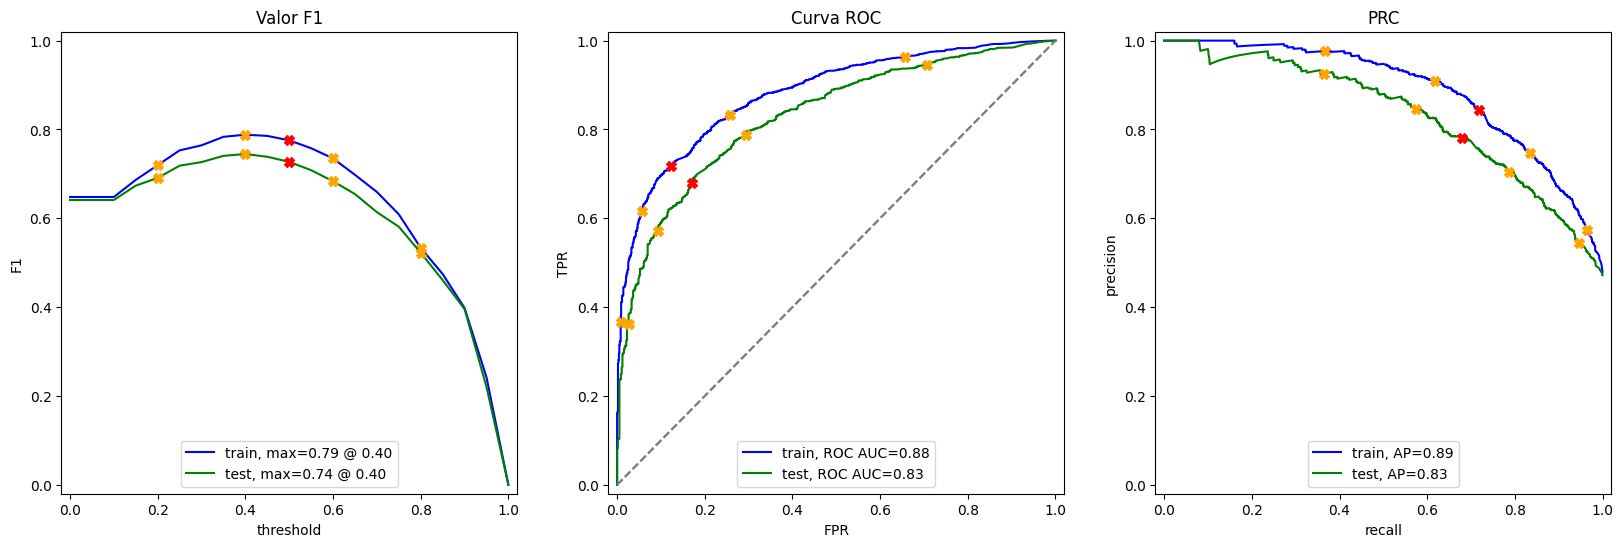

In [44]:
evaluate_model(forest_model, caract_entre, obj_entre, caract_prueba, obj_prueba)

# Conclusiones: RandomForestClassifier

Este modelo es más robusto que un simple árbol.

En este caso utilizamos un modelo con un máximo de 10 árboles, en el que cada uno tiene una profundidad máxima de 6 y no hay límite a los nodos que puede utilizar.

Iteramos sobre los parámetroc para llegar a la combinación más efectiva.

Aún así no llegamos a el ROC AUV deseado, siendo este mayor o igual a 0.88, aunque obtuvimos una calificación de ROC AUC de 0.88 al entrenar el modelo y de 0.83 con el set de prueba.

Seguiremos explorando otros modelos para llegar al objetivo planteado.

# 3.3 Tercer modelo: KNeighborClassifier

Ahora utilicemos un modelo distinto, en donde comparamos características con valores similares para clasificar nuestro modelo.
Este modelo tiene integrado parámetros más rebustos que nos pueden ayudar a llegar a el objetivo planteado.

In [45]:
for n in range(15, 45): #Haremos un for para escoger la cantidad de vecienos ideales para el modelo.
     kn_model = KNeighborsClassifier(n_neighbors=n)
     kn_model.fit(caract_entre, obj_entre)
     kn_predict = kn_model.predict(caract_prueba)
     pred_proba = kn_model.predict_proba(caract_valid)[:,1]
     aps = metrics.average_precision_score(obj_valid, pred_proba)
     print("Cantidad de vecinos:", n)
     print("Valuación de dataset de prueba en NearestNeighbors: ", kn_model.score(caract_prueba, obj_prueba))
     print('F1:', metrics.f1_score(obj_prueba, kn_predict))
     print('ROC AUC:', metrics.roc_auc_score(obj_valid, pred_proba))
     print('APS:', aps)
     print()

Cantidad de vecinos: 15
Valuación de dataset de prueba en NearestNeighbors:  0.7347439435755904
F1: 0.6918418240114002
ROC AUC: 0.7853886522453297
APS: 0.7590424241949713

Cantidad de vecinos: 16
Valuación de dataset de prueba en NearestNeighbors:  0.7329040171726464
F1: 0.6829268292682926
ROC AUC: 0.7871495587293633
APS: 0.7600075467361809

Cantidad de vecinos: 17
Valuación de dataset de prueba en NearestNeighbors:  0.7329040171726464
F1: 0.6829268292682926
ROC AUC: 0.7867476126840948
APS: 0.759675100326083

Cantidad de vecinos: 18
Valuación de dataset de prueba en NearestNeighbors:  0.7310640907697026
F1: 0.673613695571269
ROC AUC: 0.7885467997438681
APS: 0.7633938813357403

Cantidad de vecinos: 19
Valuación de dataset de prueba en NearestNeighbors:  0.7371971787795155
F1: 0.701289647960962
ROC AUC: 0.7906278710431804
APS: 0.773060497900017

Cantidad de vecinos: 20
Valuación de dataset de prueba en NearestNeighbors:  0.7368905243790248
F1: 0.6937901498929335
ROC AUC: 0.79149614410200

In [46]:
kn_model = KNeighborsClassifier(n_neighbors=38, algorithm='ball_tree')
kn_model.fit(caract_entre, obj_entre)
kn_predict = kn_model.predict(caract_prueba)
pred_proba = kn_model.predict_proba(caract_valid)[:,1]
aps = metrics.average_precision_score(obj_valid, pred_proba)
print("Valuación de dataset de prueba en NearestNeighbor: ", kn_model.score(caract_prueba, obj_prueba))
print('F1:', metrics.f1_score(obj_prueba, kn_predict))
print('ROC AUC:', metrics.roc_auc_score(obj_valid, pred_proba))
print('APS:', aps)

Valuación de dataset de prueba en NearestNeighbor:  0.7405703771849126
F1: 0.6948051948051948
ROC AUC: 0.8025070297057267
APS: 0.7932941816632322


In [47]:
kn_model = KNeighborsClassifier(n_neighbors=38, algorithm='kd_tree')
kn_model.fit(caract_entre, obj_entre)
kn_predict = kn_model.predict(caract_prueba)
pred_proba = kn_model.predict_proba(caract_valid)[:,1]
aps = metrics.average_precision_score(obj_valid, pred_proba)
print("Valuación de dataset de prueba en Nearestneighbor: ", kn_model.score(caract_prueba, obj_prueba))
print('F1:', metrics.f1_score(obj_prueba, kn_predict))
print('ROC AUC:', metrics.roc_auc_score(obj_valid, pred_proba))
print('APS:', aps)

Valuación de dataset de prueba en Nearestneighbor:  0.7405703771849126
F1: 0.6948051948051948
ROC AUC: 0.8025348701244467
APS: 0.7933254145863861


In [48]:
kn_model = KNeighborsClassifier(n_neighbors=38, algorithm='brute')
kn_model.fit(caract_entre, obj_entre)
kn_predict = kn_model.predict(caract_prueba)
pred_proba = kn_model.predict_proba(caract_valid)[:,1]
aps = metrics.average_precision_score(obj_valid, pred_proba)
print("Valuación de dataset de prueba en NearestNeighbor: ", kn_model.score(caract_prueba, obj_prueba))
print('F1:', metrics.f1_score(obj_prueba, kn_predict))
print('ROC AUC:', metrics.roc_auc_score(obj_valid, pred_proba))
print('APS:', aps)

Valuación de dataset de prueba en NearestNeighbor:  0.740263722784422
F1: 0.6943341753879466
ROC AUC: 0.8026305715637964
APS: 0.7933348493557335


In [49]:
kn_model = KNeighborsClassifier(n_neighbors=38, algorithm='kd_tree', p=1)
kn_model.fit(caract_entre, obj_entre)
kn_predict = kn_model.predict(caract_prueba)
pred_proba = kn_model.predict_proba(caract_valid)[:,1]
aps = metrics.average_precision_score(obj_valid, pred_proba)
print("Valuación de dataset de prueba en NearestNeighbor: ", kn_model.score(caract_prueba, obj_prueba))
print('F1:', metrics.f1_score(obj_prueba, kn_predict))
print('ROC AUC:', metrics.roc_auc_score(obj_valid, pred_proba))
print('APS:', aps)

Valuación de dataset de prueba en NearestNeighbor:  0.738423796381478
F1: 0.692168892096716
ROC AUC: 0.8004764191653441
APS: 0.7885600530647912


In [50]:
kn_model = KNeighborsClassifier(n_neighbors=38, algorithm='kd_tree', p=2)
kn_model.fit(caract_entre, obj_entre)
kn_predict = kn_model.predict(caract_prueba)
pred_proba = kn_model.predict_proba(caract_valid)[:,1]
aps = metrics.average_precision_score(obj_valid, pred_proba)
print("Valuación de dataset de prueba en NearestNeighbor: ", kn_model.score(caract_prueba, obj_prueba))
print('F1:', metrics.f1_score(obj_prueba, kn_predict))
print('ROC AUC:', metrics.roc_auc_score(obj_valid, pred_proba))
print('APS:', aps)

Valuación de dataset de prueba en NearestNeighbor:  0.7405703771849126
F1: 0.6948051948051948
ROC AUC: 0.8025348701244467
APS: 0.7933254145863861


<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Aquí igual que en el modelo anterior, el RMSE no debería aplicarse ya que eso solo se aplica para modelos de regresión
</div>

In [51]:
kn_model = KNeighborsClassifier(n_neighbors=38, algorithm='kd_tree', p=2)
kn_model.fit(caract_entre, obj_entre)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=38)

          train  test
Accuracy   0.77  0.74
F1         0.73  0.69
APS        0.85  0.79
ROC AUC    0.85  0.81


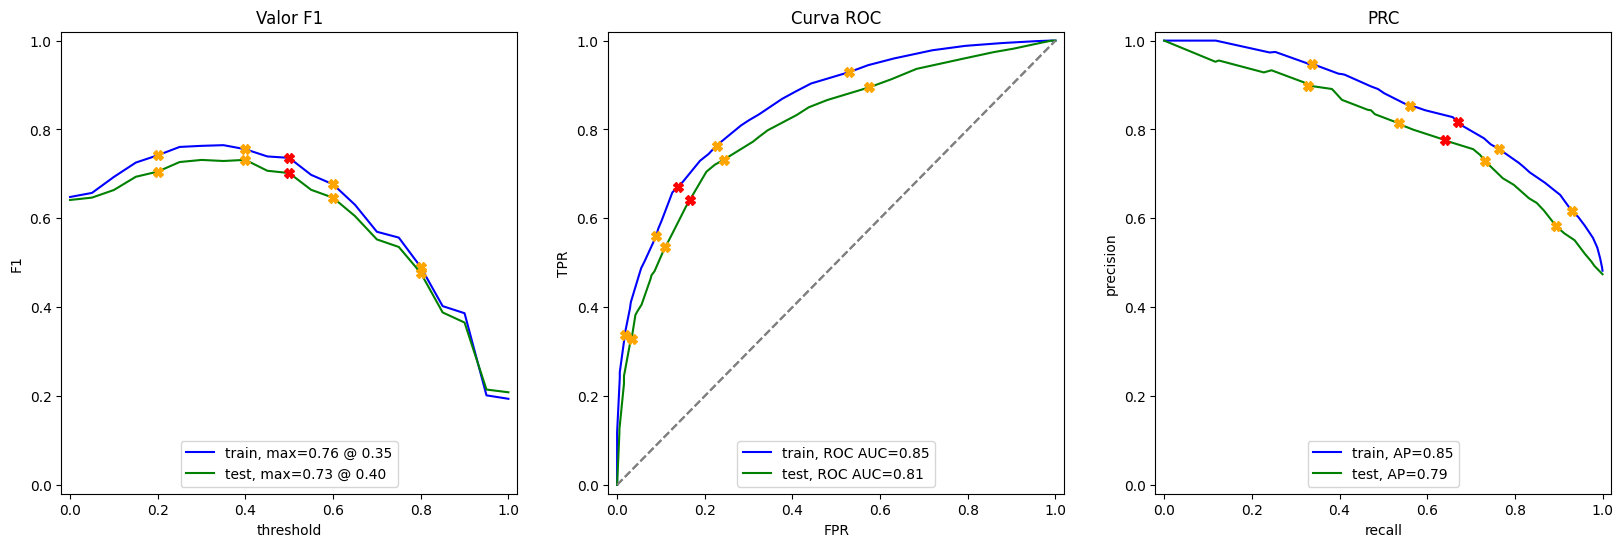

In [52]:
evaluate_model(kn_model, caract_entre, obj_entre, caract_prueba, obj_prueba)

# Conclusiones: Modelo KNeighborsClassifier

Usamos un modelo que se basa en la comparación de vecinos cercanos, utiliza carcaterísticas con valores cercanos para hacer la clasificación.

Este modelo que es más robusto, es menos efectivo que el modelo de RandomForestClassifier aunque es eficiente, no se compara con un recusros más sencillo como un bosque de clasificación.

Iteramos sobre los parámetros de cantidad de vecinos cercanos, el tipo de algoritmo a usar y si usamos ditancia manhattan o ecluidiana.

En este caso lo ideal fue dejar una cantidad de 38 vecinos cercanos, el algoritmo KD_tree de entrenamiento y seleccionar la distancia ecluidiana para entrenar.

Aún asé nuestro ROC AUC tuvo un valor final de 0.85 con el set de entrenamiento y de 0.81 al probar el modelo, esto es menos a lo que ya habiamos obtenido del modelo de bosque de clasificación.

Este modelo es bueno, pero no es el ideal para la tarea.

# 3.4 Modelo CatBoostClassifier

Ahora vamos a utilizar el modelo CatBoost, en este modelo no es necesario codificar los datos en OneHit ya que podemos indicarle cuales son las variables categóricas desde un inicio.

Para este vamos a usar otro tipo de datasets para entrenarlo.

Este modelo contiene un parametro en donde le podemos indicar el descenso de gradiante y como debería de entrenar el modelo, esto lo hace más eificente al querer buscar un objetivo.

Lo que busca este modelo con cada iteración es reducir el error dentro de la predicción, esto nos resulta muy útil al querer afinar el modelo con una mayor precisión y reducir los valores de falsos positivos.

In [53]:
entre_valid_cat, prueba_cat = train_test_split(df_merged, test_size=0.3, random_state=12345)
entrenamiento_cat, valid_cat = train_test_split(entre_valid_cat, test_size=0.25, random_state=12345)

In [54]:
cat_car_entre = entrenamiento_cat.drop('ActiveCustomers', axis=1)
cat_obj_entre =entrenamiento_cat['ActiveCustomers']

cat_car_prueba = prueba_cat.drop('ActiveCustomers', axis=1)
cat_obj_prueba = prueba_cat['ActiveCustomers']

cat_car_valid = valid_cat.drop('ActiveCustomers', axis=1)
cat_obj_valid = valid_cat['ActiveCustomers']

In [55]:
cat_car_entre, cat_obj_entre = aumento_sample(cat_car_entre, cat_obj_entre, 3)

cat_car_prueba, cat_obj_prueba = aumento_sample(cat_car_prueba, cat_obj_prueba, 3)

cat_car_valid, cat_obj_valid = aumento_sample(cat_car_valid, cat_obj_valid, 3)

In [56]:
for n in range(1, 20): #Haremos un for para escoger la cantidad de iteraciones ideales para el modelo.
     cat_model = CatBoostClassifier(iterations=n, max_depth=5, learning_rate=0.6, loss_function='Logloss', random_state=12345, cat_features=variables_categoricas)
     cat_model.fit(cat_car_entre, cat_obj_entre)
     cat_predict = cat_model.predict(cat_car_prueba)
     pred_proba = cat_model.predict_proba(cat_car_valid)[:,1]
     aps = metrics.average_precision_score(cat_obj_valid, pred_proba)
     print("Cantidad de iteraciones:", n)
     print("Valuación de dataset de prueba en CatBoost: ", cat_model.score(cat_car_prueba, cat_obj_prueba))
     print('F1:', metrics.f1_score(cat_obj_prueba, cat_predict))
     print('ROC AUC:', metrics.roc_auc_score(cat_obj_valid, pred_proba))
     print('APS:', aps)
     print()

0:	learn: 0.5605791	total: 50.2ms	remaining: 0us
Cantidad de iteraciones: 1
Valuación de dataset de prueba en CatBoost:  0.7470101195952162
F1: 0.6941045606229144
ROC AUC: 0.7918615495977059
APS: 0.7879888574899195

0:	learn: 0.5605791	total: 2.22ms	remaining: 2.22ms
1:	learn: 0.5142898	total: 4.07ms	remaining: 0us
Cantidad de iteraciones: 2
Valuación de dataset de prueba en CatBoost:  0.7519165900030665
F1: 0.706990220934444
ROC AUC: 0.815764289094908
APS: 0.8254395967354738

0:	learn: 0.5605791	total: 2.38ms	remaining: 4.75ms
1:	learn: 0.5142898	total: 4.4ms	remaining: 2.2ms
2:	learn: 0.4939339	total: 6.25ms	remaining: 0us
Cantidad de iteraciones: 3
Valuación de dataset de prueba en CatBoost:  0.7476234283961974
F1: 0.7170849089034033
ROC AUC: 0.8224825301372534
APS: 0.832418552439871

0:	learn: 0.5605791	total: 2.34ms	remaining: 7.03ms
1:	learn: 0.5142898	total: 4.18ms	remaining: 4.18ms
2:	learn: 0.4939339	total: 5.97ms	remaining: 1.99ms
3:	learn: 0.4801066	total: 8.04ms	remaining: 

4:	learn: 0.4712832	total: 10.6ms	remaining: 23.4ms
5:	learn: 0.4650162	total: 12.9ms	remaining: 21.5ms
6:	learn: 0.4607909	total: 14.7ms	remaining: 18.9ms
7:	learn: 0.4587699	total: 16.5ms	remaining: 16.5ms
8:	learn: 0.4549089	total: 18.4ms	remaining: 14.3ms
9:	learn: 0.4526418	total: 20.2ms	remaining: 12.1ms
10:	learn: 0.4509213	total: 22ms	remaining: 9.99ms
11:	learn: 0.4500746	total: 23.8ms	remaining: 7.93ms
12:	learn: 0.4496431	total: 25.6ms	remaining: 5.91ms
13:	learn: 0.4467956	total: 27.7ms	remaining: 3.95ms
14:	learn: 0.4431503	total: 29.7ms	remaining: 1.98ms
15:	learn: 0.4397264	total: 31.5ms	remaining: 0us
Cantidad de iteraciones: 16
Valuación de dataset de prueba en CatBoost:  0.7641827660226924
F1: 0.7317753749564004
ROC AUC: 0.8268099752220273
APS: 0.8358625609972914

0:	learn: 0.5605791	total: 2.19ms	remaining: 35ms
1:	learn: 0.5142898	total: 4.01ms	remaining: 30.1ms
2:	learn: 0.4939339	total: 5.84ms	remaining: 27.3ms
3:	learn: 0.4801066	total: 7.91ms	remaining: 25.7ms
4

In [57]:
for depth in range(1, 11): #Haremos un for para escoger la profundidad máxima ideal para el modelo.
     cat_model = CatBoostClassifier(iterations=8, max_depth=depth, learning_rate=0.6, loss_function='Logloss', random_state=12345, cat_features=variables_categoricas)
     cat_model.fit(cat_car_entre, cat_obj_entre)
     cat_predict = cat_model.predict(cat_car_prueba)
     pred_proba = cat_model.predict_proba(cat_car_valid)[:,1]
     aps = metrics.average_precision_score(cat_obj_valid, pred_proba)
     print("Profundidad máxima:", depth)
     print("Valuación de dataset de prueba en CatBoost: ", cat_model.score(cat_car_prueba, cat_obj_prueba))
     print('F1:', metrics.f1_score(cat_obj_prueba, cat_predict))
     print('ROC AUC:', metrics.roc_auc_score(cat_obj_valid, pred_proba))
     print('APS:', aps)
     print()

0:	learn: 0.5916054	total: 1.48ms	remaining: 10.4ms
1:	learn: 0.5687120	total: 2.37ms	remaining: 7.12ms
2:	learn: 0.5412492	total: 3.53ms	remaining: 5.88ms
3:	learn: 0.5303294	total: 4.53ms	remaining: 4.53ms
4:	learn: 0.5174247	total: 5.49ms	remaining: 3.29ms
5:	learn: 0.5096138	total: 6.41ms	remaining: 2.13ms
6:	learn: 0.5030257	total: 7.38ms	remaining: 1.05ms
7:	learn: 0.4998997	total: 8.35ms	remaining: 0us
Profundidad máxima: 1
Valuación de dataset de prueba en CatBoost:  0.7513032812020852
F1: 0.7229244960710625
ROC AUC: 0.8167578440379744
APS: 0.8173598877844226

0:	learn: 0.5774213	total: 1.61ms	remaining: 11.3ms
1:	learn: 0.5453904	total: 2.76ms	remaining: 8.28ms
2:	learn: 0.5255419	total: 3.82ms	remaining: 6.36ms
3:	learn: 0.5053936	total: 4.93ms	remaining: 4.93ms
4:	learn: 0.4934010	total: 5.89ms	remaining: 3.53ms
5:	learn: 0.4849845	total: 6.92ms	remaining: 2.31ms
6:	learn: 0.4793489	total: 7.97ms	remaining: 1.14ms
7:	learn: 0.4767050	total: 9.02ms	remaining: 0us
Profundidad 

In [58]:
cat_model = CatBoostClassifier(iterations=8, max_depth=2, learning_rate=0.6, loss_function='Logloss', random_seed=42, cat_features=variables_categoricas)
cat_model.fit(cat_car_entre, cat_obj_entre)
cat_predict = cat_model.predict(cat_car_prueba)
pred_proba = cat_model.predict_proba(cat_car_valid)[:,1]
aps = metrics.average_precision_score(cat_obj_valid, pred_proba)
print("Profundidad máxima:", depth)
print("Valuación de dataset de prueba en CatBoost: ", cat_model.score(cat_car_prueba, cat_obj_prueba))
print('F1:', metrics.f1_score(cat_obj_prueba, cat_predict))
print('ROC AUC:', metrics.roc_auc_score(cat_obj_valid, pred_proba))
print('APS:', aps)
print()

0:	learn: 0.5796281	total: 1.86ms	remaining: 13ms
1:	learn: 0.5500466	total: 3.13ms	remaining: 9.4ms
2:	learn: 0.5196044	total: 4.21ms	remaining: 7.02ms
3:	learn: 0.5000364	total: 5.2ms	remaining: 5.2ms
4:	learn: 0.4899218	total: 6.25ms	remaining: 3.75ms
5:	learn: 0.4856821	total: 7.2ms	remaining: 2.4ms
6:	learn: 0.4798107	total: 8.19ms	remaining: 1.17ms
7:	learn: 0.4750469	total: 9.17ms	remaining: 0us
Profundidad máxima: 10
Valuación de dataset de prueba en CatBoost:  0.7632628028212205
F1: 0.7304469273743016
ROC AUC: 0.8268064951696873
APS: 0.833942958874361



In [59]:
cat_model = CatBoostClassifier(iterations=8, max_depth=2, learning_rate=0.6, loss_function='Logloss', random_state=54321, cat_features=variables_categoricas)
cat_model.fit(cat_car_entre, cat_obj_entre)

0:	learn: 0.5893322	total: 1.94ms	remaining: 13.6ms
1:	learn: 0.5469307	total: 3.04ms	remaining: 9.12ms
2:	learn: 0.5104494	total: 4.24ms	remaining: 7.06ms
3:	learn: 0.4969161	total: 5.28ms	remaining: 5.28ms
4:	learn: 0.4871676	total: 6.27ms	remaining: 3.76ms
5:	learn: 0.4820303	total: 7.26ms	remaining: 2.42ms
6:	learn: 0.4780051	total: 8.24ms	remaining: 1.18ms
7:	learn: 0.4749121	total: 9.57ms	remaining: 0us


          train  test
Accuracy   0.77  0.76
F1         0.75  0.73
APS        0.85  0.84
ROC AUC    0.85  0.83


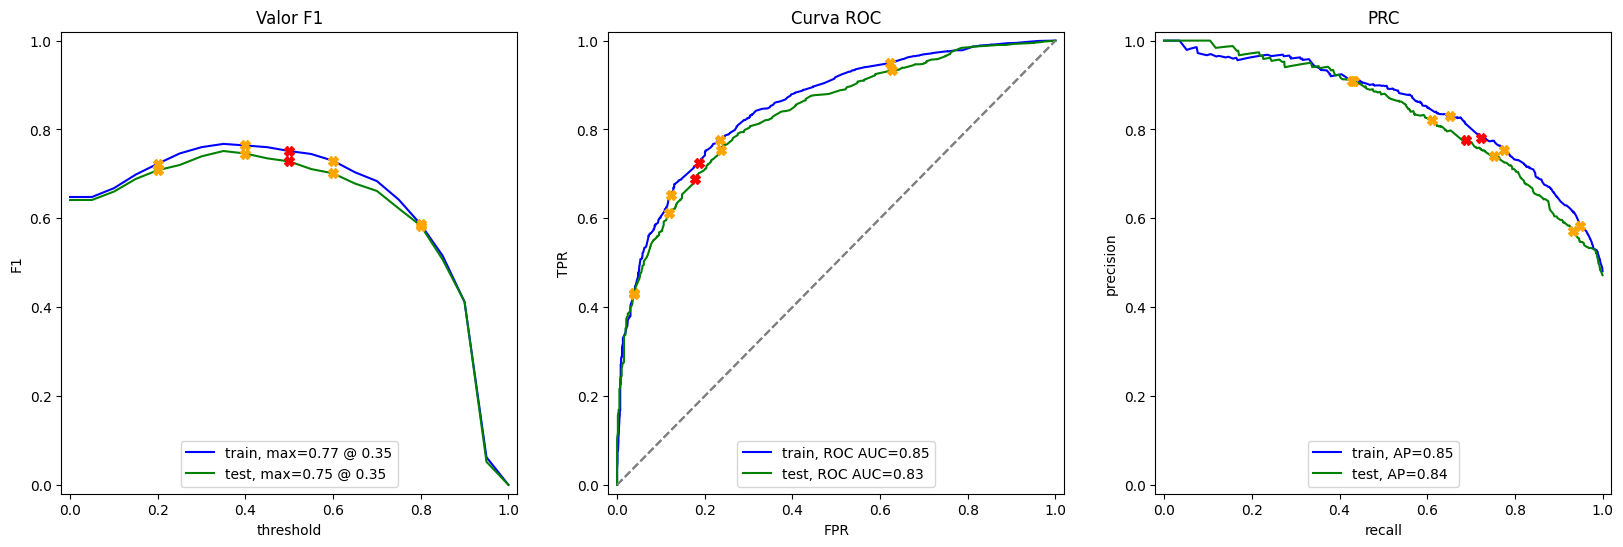

In [60]:
evaluate_model(cat_model, cat_car_entre, cat_obj_entre, cat_car_prueba, cat_obj_prueba)

# Conclusiones: CatBoostClassifier

Este modelo nos ha dejado entrenar la gradiante y varios parámetros para su mejora.

Aún así llegamos a un ROC AUC igual que el bosque de clasificación. Nuestra valuación de un 0.85 con el set de entrenamiento y un 0.83 con el set de prueba.

Este recurso usa parámetros más robustos, lo que lo hace más eficiente pero añun así no superó al bosque aleatorio de clasificación.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

La evaluación de estos últimos modelos se ven prometedoras! Se nota que no tienes sobre ajuste con estos modelos ya que las métricas son similares en entrenamiento y prueba lo que quiere decir que el modelo se ajusta correctamente
</div>

# 4. Conslusiones generales

En este proyecto realizamos una tarea exhausiva para encontrar el modelo ideal para predecir cuando un cliente va a abandonar nuestros servicios.

Para realizar esta tarea analisamos la data de 4 bases da datos distintas, las cuales nos brindaron información del comportamiento de los usuarios.

Trabajamos la información y la sintetizamos en una base de datos con información relevante de su comportamiento.

Nos percatamos de que nuestra base de datos incluye más información de clientes activos,en comparación con los que han abandonado. Esto nos indica un desbalance de clases, la cual se ajustó para entrenar los modelos.

También nos percatamos que los clientes que abandonan los servicios tienen las siguientes tendencias:

- Estos clientes realizaban las compras en línea y la facturación en línea.
- Estos clientes, en su mayoría, contrataron servicios de fibra óptica.
- Estos clientes realizaban pagos mensuales, no contaban con una contratación anual a bianual.

Analizando esto,tenemos una idea del comportamiento de los usuarios que abandanaron los servicios y sus tendencias de comportamiento.

Esto nos dá una idea de que variables son útiles para el entrenamiento del modelo.

Dejamos las variables no informativas fuera de nuestro DataFrame y empezamos a trabajar con nuestros datasets.

En este caso, como lo mencionamos antes, tenemos un desbalance de clase. Por lo cual usamos el método de Bootstraping para que la clase más rara crezca y sea igual de relevante que la clase dominante.

Además de esto definimos métricas de evaluación para nuestros modelos de clasificación.
Estas métricas nos ayudan a conocer que tan efectivo y eficiente es nuestro modelo, con eso en mente elegimos las siguientes métricas:

- Accuracy: esta métrica nos indica que tan precisas son las predicciones del modelo, nos da anetnder cuantas respuestas acertadas llega nuestro modelo.
- F1: esta métrica mide la relación entre la precisión y sensibilidad del modelo. Nos da a concoer que tan acertadas son las predicciones y si estas están sesgadas por el desbalance de clases.
- APS: nos da el promedio de respuestas acertadas, para conocer en promedio que tan buenas predicciones hace el modelo.
- ROC AUC: esta métrica nos indica la relación entre falsos positivos y verdaderos positivos. Son las respuestas que tienen una respuesta positiva cuando debió haver sido negativa y las respuestas que son delimitadas como verdaderas son certeras, relativamente.

Teniendo definida la información a utilizar y las métricas para medir nuestro modelo ya podemos empezar a iterar nuestros modelos y valuarlos.

Para esta tarea probamos con 4 modelos de clasificación diferentes  y los iteramos para afinar los parámetros de cada uno.
Utilizamos los siguientes modelos:

- DecisionTreeClassifier: este modelo es muy sencillo, en dónde utilizamos un sólo ñarbol de decisión para entrenar el modelo. Al no tener varios parámetros para iterar o más árboles de clasififcación se vuelve un recurso sencillo que puede llegar a no ser ideal con bases de datos robustas.
- RandomForestClassifier: este modelo es más robusto que el pasado. Ya que cuenta con varios árboles dentro del modelo, donde el siguiente árbol itera sobre la predicciones del pasado. Aquí podemos iterar sobre parámetros como cantidad de árboles, profundiad máxima por árbol y cantidad de nodos o respuestas finales.
- KNeighborsClassifier: este modelo se entrena comparando clientes con características cercanas uno del otro. Podemos iterar sus parámetros diciendo la cantidad de vecinos máximos que puede utilizar para su comparativo, el tipo de algoritmo a usar y la métrica de distancia (manhattan o ecluidiana)
- CatBoostClassifier: este modelo permite iterar usando el descenso de gradiante, es una métrica de distancia en donde podemos indicar que tan largo o corto es el proceso de iteración. También cuenta con parámetros como número de iteraciones dentro del modelo, indicar cuales son las variables categóricas para evitar la codficación One Hit, profundidad máxima y una función de pérdida, para que conozca que error buscamos reducir.

Después de realizar un comparativo de los modelos, iterarlos y evaluarlos, nos dimos cuenta que el modelo ideal para la tarea es el RandomForestClassifier.
Ya que llega a tener el ROC AUC más alto utilizando los menos recursos posibles, además de ser un modelo que podría ser considerado más sencillo que CatBoost o KNeighbors por los parámetros con los que cuenta al iterar.

Este modelo llega a tener un score de ROC AUC de 0.88 al entrenar el modelo y de 0.83 al ponerlo a prueba.

Llega al mismo score que el modelo CatBoost al ponerlo a prueba, lo que lo hace igual de eficiente pero usando menos recursos.

Recomendaríamos usar este modelo para su implementación.

# 5. Informe de Solución

## ¿Qué pasos del plan se realizaron y qué pasos se omitieron (explica por qué)?

Los pasos que tomar para realizar la tarea son los siguientes:

1) Análisis exploratorio de datos: lo primero y más importante es, cargar la data con la que estamos trabajando y analizarla.

Debemos saber si estamos trabajando con la data correcta, limpiar los datos que sea nulos, duplicados o no necesarios para nuestra tarea.

Al tener la data limpia, empezamos a explorar tendencias, balanceos de clases y hacemos un análisis del comportamiento de los usuarios.
Todo esto es importante ya que debemos saber si contamos con la data necesaria para trabajar la tarea y en caso de tenerla, cómo se presenta, cual es necesaria y explorar comportamientos dentro de esta.

2) Datasets, Bootstraping y Métricas de evaluación: conociendo la tarea que debemos realizar tenemos en cuenta que data se va a utilizar y cuales métricas se deben de utilizar para evaluarla.

En este caso deividimos la data en datasets de entrenamiento, prueba y validación, todo con la intención de contar con la data necesaria para la utilización del modelo.

Luego relizamos un método llamada Bootstraping, en donde ajustamos los balances de las clases para que la clase más rara se equilibre con la clase dominante. En este caso aumentamos el tamaño de la clase rara para entrenar al modelo a que pueda predecir cuando los usuarios van a abandonar el servicio.

Finalmente elegimos la métricas de evaluación. Estas son necesarias ya que nos indican la eficiencia del modelo, al ser una tarea de clasificación utilizamos métricas con la que podamos valuar este tipo de modelos.
Aqui decidimos utilizar la métrica de presición, sensibilidad, F1(relación de precisión y sensibilidad) y el ROC AUC el cual valúa la relación de Falsos Poristivos vs. Verdaderos Positivos.

3) Entrenamiento de Modelos e Iteración: al tener los datasets codificados, con data limpia, con un ajuste de clase y métricas de evaluación definida toca entrenar lo modelos.

Para la tarea entrenamos 4 modelos de clasificación distintos: DecisionTreeClassifier, RandomForestClassifier, KNeighborsClassifier y CatBoostClassifier.
Todos estos modelos cuentan con parámetros que pueden ser ajustados para iterar el modelo y llegar al mejore entrenamiento usando los menos recursos posibles.
Cada uno fue iterado para pulirse en su mejor versión y valuado con nuestras métricas establecidas.
Luego realizamos una conclusión sobre cada modelo y elegimos el que consideramos el mejor para la tarea.

4) Conclusiones generales: al finalizar la tarea es importante dar a conocer cómo se estructuró la tarea, los pasos a seguir, las conclusiones de cada paso y la justificación del modelo seleccionado.
Dentro de estas conclusiones damos a conocer la lógica detrás de lo trabajado y las conclusiones de cada uno de estos pasos.

## ¿Qué dificultades encontraste y cómo lograste resolverlas?

Una gran dificultad dentro de esta tarea fue rellenar los datos faltantes en la columna de 'TotalCharges', ya que es información que debió estar disponible para usarse pero no teníamos a la mano.
Después de investigar y apoyarnos de nuestro mentor, delimitamos que la mejor solución era usar un KNimputer para rellenar los datos faltantes.
Rellenando esta información con data vecina/similar a la de usuarios parecidos.

Con el resto de los pasos no hubo dificultad y utilicé los recursos del Diplomado para resolver la tarea.

## ¿Cuáles fueron algunos de los pasos clave para resolver la tarea?

Creo que el paso clave y más importante es el primero, el Análisis Exploratorio de Datos. Ya que aqui es donde realmente vemos que información está disponible y cómo se puede aplicar para resolver la tarea.
Aqui es donde vemos si hace falta información, si es necesario enriquecer los datos, vemos tendencias de los usuarios y conocesmo si hay un desbalance de clase.
Este paso es prácticamente el pilar que va a dictar que tan bueno va a ser nuestro modelo y si se apega a la necesidad de la tarea.

## ¿Cuál es tu modelo final y qué nivel de calidad tiene?

El modelo que decidí que es el final y el que recomendaría usar es el RandomForestClassifier, ya que es un modelo lo suficientemente robusto para resolver la tarea y no ocupa más recursoso como el KNeighborsClassifier o el CatBoostClassifier.

Además, este modelo llega a tener una valuación alta acorde a las métricas usadas.
Dándonos los siguientes resultados:

Métrica     train  test

Accuracy     0.80  0.76

F1           0.78  0.73

APS          0.89  0.83

ROC AUC      0.88  0.83

Esto lo hace el modelo más eficiente y eficaz, usando los menos recursos posibles y llegando a los resulados más precisos.
Llega a tener mejor resultados que el modelo CatBoostClassifier y sin necesidad de iterar tantas veces con el modelo o utilizar el parámeto de descenso de gradiante incluido en el modelo CatBoostClassifier.